---

## Portfolio Management

How will portfolio management will be used:

1. Will handle the data and its length (it will call the data that is going to be used by all individual strategies)
2. Will call each strategy and get its returns columns (Will loop over each strategy class)
-> Note: Each strategy will already have an optimizer in each of their class (will be already walk forwarded)
3. Construct relevant methods

Thus:
- A method to call all strategies data + combines all of their cumulative return into one df
- Methods that calculates any factors affecting the choice of the strategies as well as their weights (Correlations, Market Regime, ...)

The portfolio management is a layer that manages the current best strategies and its objective is to generate a weight multiplier for each strategy based on factors allowing dynamic rebalancing. It classifies strategies, Calculates the correlation between strategies, provide a market regime detection model that may impact the weights of specific strategy types, ...


Note that everything in this module will be applied before running the process of optimization. Any management layers occuring after the rebalancing, are located inside the portfolio risk management module.


---

idea for portfolio management: get all the strategies -> run them -> do that analysis and filtering (correlation analysis, ...)

Get the data, and call all strategies to get the out of sample performance

In [1]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Data_Management'))) 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Trend_Following')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'Strategies', 'Mean_Reversion')))

# Import the modules
from data import Data
from sprtrnd_breakout import Sprtrnd_Breakout
from last_days_low import Last_Days_Low


In [2]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [2]:
start_time = dt.datetime(2024, 7, 1)
end_time = dt.datetime(2025, 1, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns      high  log_return  \
date                coin                                                
2024-07-01 01:00:00 BTCUSDT  63640.82  1.011263  63730.00    0.011200   
                    ETHUSDT   3519.40  1.022184   3520.00    0.021942   
2024-07-01 02:00:00 BTCUSDT  63435.86  1.008007  63818.33   -0.003226   
                    ETHUSDT   3502.28  1.017212   3524.94   -0.004876   
2024-07-01 03:00:00 BTCUSDT  63437.69  1.008036  63536.47    0.000029   
...                               ...       ...       ...         ...   
2024-12-31 21:00:00 ETHUSDT   3352.75  0.973782   3354.44    0.001956   
2024-12-31 22:00:00 BTCUSDT  93488.84  1.485554  93899.67   -0.004385   
                    ETHUSDT   3339.88  0.970044   3352.64   -0.003846   
2024-12-31 23:00:00 BTCUSDT  93576.00  1.486939  93756.00    0.000932   
                    ETHUSDT   3337.78  0.969434   3345.98   -0.000629   

                                  low      open     price   returns  \
date                coin                                              
2024-07-01 01:00:00 BTCUSDT  62901.71  62931.98  63640.82  0.011263   
                    ETHUSDT   3440.50   3443.02   3519.40  0.022184   
2024-07-01 02:00:00 BTCUSDT  63288.53  63640.81  63435.86 -0.003221   
                    ETHUSDT   3494.40   3519.40   3502.28 -0.004864   
2024-07-01 03:00:00 BTCUSDT  63340.00  63435.86  63437.69  0.000029   
...                               ...       ...       ...       ...   
2024-12-31 21:00:00 ETHUSDT   3332.00   3346.20   3352.75  0.001957   
2024-12-31 22:00:00 BTCUSDT  93375.58  93899.67  93488.84 -0.004375   
                    ETHUSDT   3329.00   3352.64   3339.88 -0.003839   
2024-12-31 23:00:00 BTCUSDT  93375.38  93488.83  93576.00  0.000932   
                    ETHUSDT   3328.47   3339.88   3337.78 -0.000629   

                                  volume  volume_in_dollars  
date                coin                                     
2024-07-01 01:00:00 BTCUSDT   2570.40171       1.635825e+08  
                    ETHUSDT  35324.27340       1.243202e+08  
2024-07-01 02:00:00 BTCUSDT   2037.33231       1.292399e+08  
                    ETHUSDT  18288.98980       6.405316e+07  
2024-07-01 03:00:00 BTCUSDT   1264.46281       8.021460e+07  
...                                  ...                ...  
2024-12-31 21:00:00 ETHUSDT   7845.73080       2.630477e+07  
2024-12-31 22:00:00 BTCUSDT    315.53272       2.949879e+07  
                    ETHUSDT   8990.50650       3.002721e+07  
2024-12-31 23:00:00 BTCUSDT    336.57995       3.149581e+07  
                    ETHUSDT   6082.78830       2.030301e+07  

[8830 rows x 10 columns]

In [6]:
market_data = pd.read_csv('market_data copy.csv', index_col=['date', 'coin'], parse_dates=['date'])
market_data

close  creturns      high  log_return  \
date                coin                                                
2024-09-30 01:00:00 BTCUSDT  64769.99  0.989401  65544.00   -0.010656   
                    ETHUSDT   2615.17  0.987348   2655.80   -0.012732   
2024-09-30 02:00:00 BTCUSDT  64376.01  0.983383  64810.00   -0.006101   
                    ETHUSDT   2613.27  0.986631   2622.00   -0.000727   
2024-09-30 03:00:00 BTCUSDT  64553.68  0.986097  64580.34    0.002756   
...                               ...       ...       ...         ...   
2025-01-15 03:00:00 ETHUSDT   3236.99  1.004425   3236.99    0.007847   
2025-01-15 04:00:00 BTCUSDT  97155.10  1.006162  97600.00   -0.000461   
                    ETHUSDT   3226.49  1.001167   3248.37   -0.003249   
2025-01-15 05:00:00 BTCUSDT  96885.50  1.003370  97175.10   -0.002779   
                    ETHUSDT   3224.24  1.000469   3226.50   -0.000698   

                                  low      open     price   returns  \
date                coin                                              
2024-09-30 01:00:00 BTCUSDT  64699.98  65463.86  64769.99 -0.010599   
                    ETHUSDT   2613.50   2648.68   2615.17 -0.012652   
2024-09-30 02:00:00 BTCUSDT  64335.36  64769.99  64376.01 -0.006083   
                    ETHUSDT   2601.12   2615.17   2613.27 -0.000727   
2024-09-30 03:00:00 BTCUSDT  64190.00  64376.01  64553.68  0.002760   
...                               ...       ...       ...       ...   
2025-01-15 03:00:00 ETHUSDT   3207.43   3211.69   3236.99  0.007877   
2025-01-15 04:00:00 BTCUSDT  97100.00  97200.00  97155.10 -0.000461   
                    ETHUSDT   3222.31   3236.99   3226.49 -0.003244   
2025-01-15 05:00:00 BTCUSDT  96765.70  97155.10  96885.50 -0.002775   
                    ETHUSDT   3216.51   3226.50   3224.24 -0.000697   

                                   volume  volume_in_dollars  
date                coin                                      
2024-09-30 01:00:00 BTCUSDT   1424.060870       9.223641e+07  
                    ETHUSDT  17982.982100       4.702856e+07  
2024-09-30 02:00:00 BTCUSDT   1652.436740       1.063773e+08  
                    ETHUSDT  17612.894800       4.602725e+07  
2024-09-30 03:00:00 BTCUSDT   1817.790780       1.173451e+08  
...                                   ...                ...  
2025-01-15 03:00:00 ETHUSDT    575.363653       1.862446e+06  
2025-01-15 04:00:00 BTCUSDT     54.336455       5.279064e+06  
                    ETHUSDT    175.828958       5.673104e+05  
2025-01-15 05:00:00 BTCUSDT     11.885451       1.151528e+06  
                    ETHUSDT     60.258220       1.942870e+05  

[5146 rows x 10 columns]

---

Call each Strategy

In [8]:
mr_strat_1 = Last_Days_Low(market_data, objective = 'multiple', train_size = 440, test_size = 200, step_size = 200)
tf_strat_1 = Sprtrnd_Breakout(market_data, objective = 'multiple', train_size = 440, test_size = 200, step_size = 200)

In [ ]:
mr_strat_1.test()

Train: 2024-09-30 01:00:00 - 2024-10-18 08:00:00
Test: 2024-10-18 09:00:00 - 2024-10-26 16:00:00
length of data: 880
Train: 2024-10-08 09:00:00 - 2024-10-26 16:00:00
Test: 2024-10-26 17:00:00 - 2024-11-04 00:00:00
length of data: 880
Train: 2024-10-16 17:00:00 - 2024-11-04 00:00:00
Test: 2024-11-04 01:00:00 - 2024-11-12 08:00:00
Train: 2024-10-25 01:00:00 - 2024-11-12 08:00:00
Test: 2024-11-12 09:00:00 - 2024-11-20 16:00:00
length of data: 880
length of data: 880
Train: 2024-11-02 09:00:00 - 2024-11-20 16:00:00
Test: 2024-11-20 17:00:00 - 2024-11-29 00:00:00
length of data: 880
Train: 2024-11-10 17:00:00 - 2024-11-29 00:00:00
Test: 2024-11-29 01:00:00 - 2024-12-07 08:00:00
length of data: 880
Train: 2024-11-19 01:00:00 - 2024-12-07 08:00:00
Test: 2024-12-07 09:00:00 - 2024-12-15 16:00:00
length of data: 880
Train: 2024-11-27 09:00:00 - 2024-12-15 16:00:00
Test: 2024-12-15 17:00:00 - 2024-12-24 00:00:00
length of data: 880
Train: 2024-12-05 17:00:00 - 2024-12-24 00:00:00
Test: 2024-12-2

In [4]:
tf_strat_1.test()

Train: 2024-07-01 01:00:00 - 2024-07-19 08:00:00
Test: 2024-07-19 09:00:00 - 2024-07-27 16:00:00
Train: 2024-07-09 09:00:00 - 2024-07-27 16:00:00
Test: 2024-07-27 17:00:00 - 2024-08-05 00:00:00
length of data: 880
length of data: 880
Train: 2024-07-17 17:00:00 - 2024-08-05 00:00:00
Test: 2024-08-05 01:00:00 - 2024-08-13 08:00:00
length of data: 880
Train: 2024-07-26 01:00:00 - 2024-08-13 08:00:00
Test: 2024-08-13 09:00:00 - 2024-08-21 16:00:00
Signal Generated
length of data: 880
Train: 2024-08-03 09:00:00 - 2024-08-21 16:00:00
Test: 2024-08-21 17:00:00 - 2024-08-30 00:00:00
Signal Generated
length of data: 880
Train: 2024-08-11 17:00:00 - 2024-08-30 00:00:00
Test: 2024-08-30 01:00:00 - 2024-09-07 08:00:00
Signal Generated
length of data: 880
Train: 2024-08-20 01:00:00 - 2024-09-07 08:00:00
Test: 2024-09-07 09:00:00 - 2024-09-15 16:00:00
length of data: 880
Train: 2024-08-28 09:00:00 - 2024-09-15 16:00:00
Test: 2024-09-15 17:00:00 - 2024-09-24 00:00:00
length of data: 880
Train: 2024-0

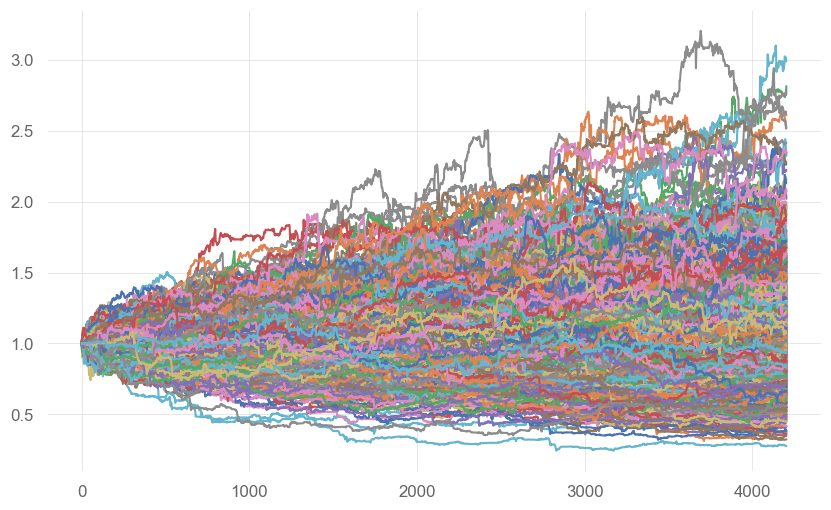

In [6]:
mr_strat_1.stress_test()

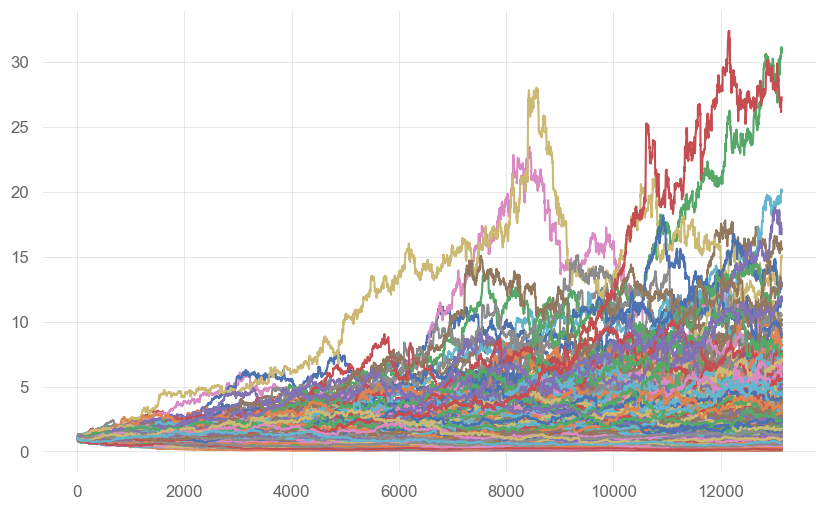

In [7]:
tf_strat_1.stress_test()

In [21]:
tf_strat_1.metrics_df.describe()

,max_drawdown,avg_drawdown,avg_drawdown_duration,sharpe_ratio,var,cvar
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.696031,-0.272780,107.542913,0.027144,-0.012900,-0.024468
std,0.119510,0.111762,99.940546,0.012969,0.000550,0.001516
min,-0.975991,-0.818909,1.666667,-0.018411,-0.015011,-0.029757
25%,-0.786858,-0.325005,66.695120,0.017933,-0.013305,-0.025509
50%,-0.693072,-0.246398,84.334791,0.027582,-0.012919,-0.024401
75%,-0.605630,-0.193455,118.088645,0.035682,-0.012484,-0.023397
max,-0.365868,-0.093280,2085.166667,0.068697,-0.011181,-0.020118


In [22]:
mr_strat_1.metrics_df.describe()

,max_drawdown,avg_drawdown,avg_drawdown_duration,sharpe_ratio,var,cvar
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.400435,-0.149600,58.369951,0.026993,-0.011008,-0.019650
std,0.114411,0.080898,68.678246,0.020992,0.000626,0.001751
min,-0.791304,-0.561319,0.000000,-0.033790,-0.013209,-0.027173
25%,-0.474041,-0.190074,30.953115,0.011613,-0.011435,-0.020850
50%,-0.389587,-0.128266,42.379189,0.026125,-0.011185,-0.019559
75%,-0.311804,-0.090817,62.315363,0.040863,-0.010548,-0.018399
max,-0.175872,-0.033783,1111.000000,0.091719,-0.008671,-0.014878


<Axes: xlabel='date,coin'>

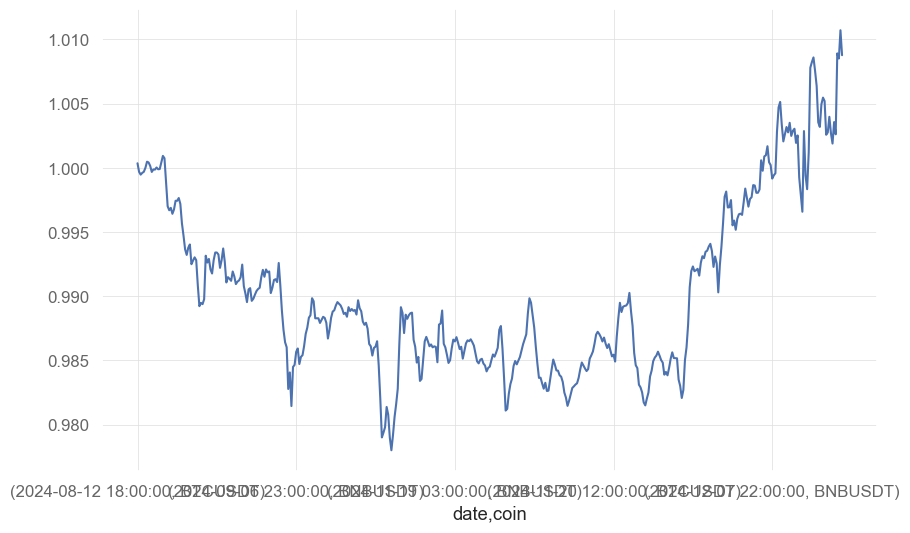

In [ ]:
mr_strat_1.results.cstrategy.plot()

<Axes: xlabel='date,None'>

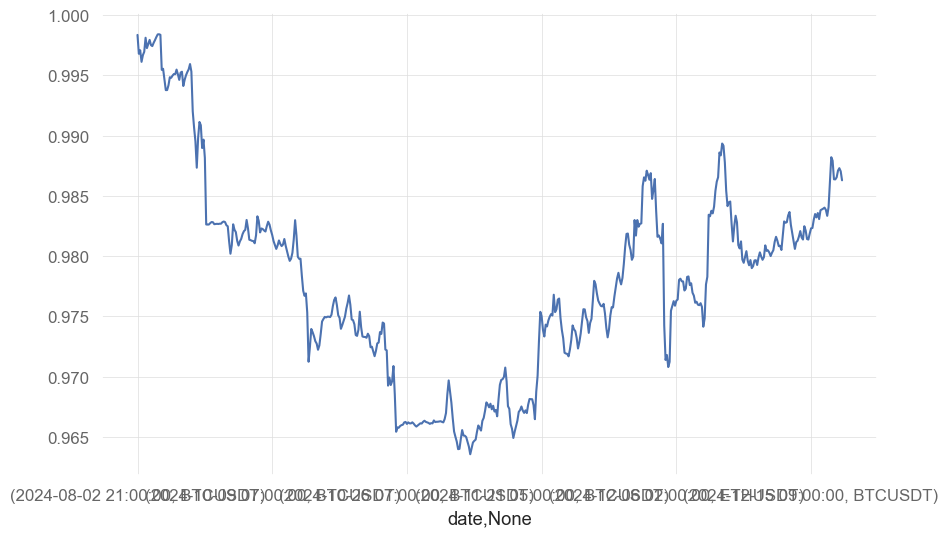

In [7]:
tf_strat_1.results.cstrategy.plot()

In [ ]:
(tf_strat_1.results.strategy * 1/4).cumsum().apply(np.exp).plot()

In [8]:
data.to_csv('sample_data.csv')    

In [67]:
#Create a dummy results that represents holding cash where the value of the portfolio is constant
cash_df = pd.DataFrame(data = {'strategy': np.zeros(data.shape[0]), 'portfolio_value': np.ones(data.shape[0])}, index = data.index)

In [68]:
cash_df

strategy  portfolio_value
date                coin                              
2020-01-01 01:00:00 ADAUSDT       0.0              1.0
                    BNBUSDT       0.0              1.0
                    BTCUSDT       0.0              1.0
                    ETHUSDT       0.0              1.0
                    XRPUSDT       0.0              1.0
...                               ...              ...
2020-12-31 23:00:00 ADAUSDT       0.0              1.0
                    BNBUSDT       0.0              1.0
                    BTCUSDT       0.0              1.0
                    ETHUSDT       0.0              1.0
                    XRPUSDT       0.0              1.0

[43825 rows x 2 columns]

In [186]:
strategy_map = {'cash_strat': cash_df.strategy,
                'mr_strat_1': mr_strat_1.results.strategy,
                'tf_strat_1': tf_strat_1.results.strategy}

---

Correlation Analysis

In [187]:
#Concatenate the results of the two strategies
list_strategies = [value for value in strategy_map.values()]
list_strategies

[date                 coin   
 2020-01-01 01:00:00  ADAUSDT    0.0
                      BNBUSDT    0.0
                      BTCUSDT    0.0
                      ETHUSDT    0.0
                      XRPUSDT    0.0
                                ... 
 2020-12-31 23:00:00  ADAUSDT    0.0
                      BNBUSDT    0.0
                      BTCUSDT    0.0
                      ETHUSDT    0.0
                      XRPUSDT    0.0
 Name: strategy, Length: 43825, dtype: float64,
 date                 coin   
 2020-01-25 12:00:00  ADAUSDT   -0.005726
                      ETHUSDT   -0.002410
 2020-01-25 13:00:00  ADAUSDT    0.004082
                      BTCUSDT    0.003204
                      ETHUSDT    0.006428
                                   ...   
 2020-10-10 17:00:00  XRPUSDT    0.000012
 2020-10-10 18:00:00  XRPUSDT    0.001073
 2020-10-10 19:00:00  XRPUSDT   -0.000597
 2020-10-10 20:00:00  XRPUSDT   -0.000476
 2020-11-13 04:00:00  ADAUSDT   -0.003856
 Name: strategy, Length

In [201]:
all_strategy = pd.concat(strategy_map, axis = 1)

In [202]:
all_strategy

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN
...                                 ...         ...         ...
2020-12-31 23:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN

[43825 rows x 3 columns]

In [203]:
#Get the correlation matrix
corr_matrix = all_strategy.corr()
corr_matrix

,cash_strat,mr_strat_1,tf_strat_1
cash_strat,NaN,NaN,NaN
mr_strat_1,NaN,1.000000,0.860956
tf_strat_1,NaN,0.860956,1.000000


In [204]:
corr_matrix.iloc[1, 2]

0.8609555080077618

In [205]:
def select_low_corr_strategies(corr_matrix, low_corr_threshold):
    """Selects strategies with low correlations from a correlation matrix."""
    selected_strategies = [corr_matrix.columns[1]]

    for i in range(1, len(corr_matrix.columns)):
        candidate_strategy = corr_matrix.columns[i]
        correlations_with_selected = corr_matrix.loc[selected_strategies, candidate_strategy]
        if all(corr < low_corr_threshold for corr in correlations_with_selected):
            selected_strategies.append(candidate_strategy)
    
    selected_strategies.append(corr_matrix.columns[0])
    return selected_strategies

In [206]:
selected = select_low_corr_strategies(corr_matrix, 0.9)

In [207]:
selected

['mr_strat_1', 'tf_strat_1', 'cash_strat']

In [211]:
#Get a new list for the selected strategies
filtered_strategies = {strategy_name : strategy for strategy_name, strategy in strategy_map.items() if strategy_name in selected}

In [215]:
filtered_strategy_map = pd.concat(filtered_strategies, axis = 1)
filtered_strategy_map

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN
...                                 ...         ...         ...
2020-12-31 23:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN

[43825 rows x 3 columns]

Putting All together:

In [222]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt


class Portfolio_Management():
    def __init__(self, strategy_map):
        self.strategy_map = strategy_map   
        
    def get_filtered_strategies(self, selected, strategy_map):
        """Filters the strategies based on the selected strategies."""
        filtered_strategies = {strategy_name : strategy for strategy_name, strategy in strategy_map.items() if strategy_name in selected}
        return pd.concat(filtered_strategies, axis = 1)
    
    def filter_by_correlation(self, low_corr_threshold = 0.9):
        """
        Filter the strategies by correlation
        """
        #Concatenate the map, to get one dataframe
        all_strategy = pd.concat(self.strategy_map, axis = 1)
    
        #Calculate the correlation matrix  
        corr_matrix = all_strategy.corr()

        #Perform the correlation analysis:
        selected_strategies = [corr_matrix.columns[1]]

        for i in range(1, len(corr_matrix.columns)):
            candidate_strategy = corr_matrix.columns[i]
            correlations_with_selected = corr_matrix.loc[selected_strategies, candidate_strategy]
            if all(corr < low_corr_threshold for corr in correlations_with_selected):
                selected_strategies.append(candidate_strategy)
        
        selected_strategies.append(corr_matrix.columns[0])
        
        
        #Get a new list for the selected strategies
        filtered_strategies = self.get_filtered_strategies(selected_strategies, self.strategy_map)
        
        return filtered_strategies

In [223]:
portfolio_management = Portfolio_Management(strategy_map)

In [224]:
portfolio_management.filter_by_correlation()

cash_strat  mr_strat_1  tf_strat_1
date                                                           
2020-01-01 01:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN
...                                 ...         ...         ...
2020-12-31 23:00:00 ADAUSDT         0.0         NaN         NaN
                    BNBUSDT         0.0         NaN         NaN
                    BTCUSDT         0.0         NaN         NaN
                    ETHUSDT         0.0         NaN         NaN
                    XRPUSDT         0.0         NaN         NaN

[43825 rows x 3 columns]